In [1]:
import json
import numpy as np
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from time import sleep, time
import pandas as pd
import warnings
from bs4 import BeautifulSoup
import requests
import time


warnings.filterwarnings('ignore')

# create an empty list to store urls.
base_urls = []
urls = []
errors = []

seasons = [2014,2015,2016,2017,2018,2019,2020,2021,2022]

##'La_Liga', 'Bundesliga', 'Ligue_1', 'Serie_A'

competitions = ['EPL']

for competition in competitions:
    for season in seasons:
        base_url = f'https://understat.com/league/{competition}/{season}'
        base_urls.append(base_url)

        season_col_value = int(base_url[-4:])
        competition_value = competition

        option = Options()
        option.headless = True
        driver = webdriver.Chrome("C:/Users/paulc/Documents/Understat_xG/chromedriver.exe", options=option)
        driver.get(base_url)

        print("Collecting Urls for", base_url)

        # Loop until the button is disabled
        while True:

            # Fetch the current page URLs
            elements = driver.find_elements(By.CSS_SELECTOR, 'a.match-info')
            page_urls = [element.get_attribute('href') for element in elements]

            # Store the URLs in the main list
            urls.extend(page_urls)

            # Scroll down or perform any necessary actions to load the next page

            # Wait for a short duration to allow the next page to load
            sleep(3)

            # Click the button to navigate to the next page
            next_button = driver.find_element(By.XPATH, "/html/body/div[1]/div[3]/div[2]/div/div/button[1]")
            next_button.click()

            # Check if the button is disabled
            button_disabled = driver.find_element(By.XPATH,
                                                  "/html/body/div[1]/div[3]/div[2]/div/div/button[1]").get_attribute(
                "disabled")
            if button_disabled:
                # Fetch the current page URLs
                elements = driver.find_elements(By.CSS_SELECTOR, 'a.match-info')
                page_urls = [element.get_attribute('href') for element in elements]

                # Store the URLs in the main list
                urls.extend(page_urls)
                break

        driver.quit()

print("The number of games extracted for data cleaning is: ", len(urls))

The number of games extracted for data cleaning is:  3420


In [2]:
match_data = []

for id in urls:
#Use requests to get the webpage and BeautifulSoup to parse the page
    res = requests.get(id)
    soup = BeautifulSoup(res.content, 'lxml')
    scripts = soup.find_all('script')
#get only the shotsData
    strings = scripts[1].string

# strip unnecessary symbols and get only JSON data
    ind_start = strings.index("('")+2
    ind_end = strings.index("')")
    json_data = strings[ind_start:ind_end]
    json_data = json_data.encode('utf8').decode('unicode_escape')

#convert string to json format
    data = json.loads(json_data)
#iterate JSON and extend match_data with a list of dicts
    match_data.extend([d for k in data.keys() for d in data[k]])

global epl
epl = pd.DataFrame(match_data)

In [4]:
epl.head()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,21455,4,SavedShot,0.9530000305175781,0.33799999237060546,0.07463619858026505,Callum McManaman,h,880,OpenPlay,2014,RightFoot,4428,West Bromwich Albion,Chelsea,3,0,2015-05-18 20:00:00,Craig Dawson,Pass
1,21458,8,Goal,0.7559999847412109,0.5220000076293946,0.024708300828933716,Saido Berahino,h,811,OpenPlay,2014,RightFoot,4428,West Bromwich Albion,Chelsea,3,0,2015-05-18 20:00:00,Joleon Lescott,Pass
2,21460,23,BlockedShot,0.9119999694824219,0.30700000762939456,0.07130289822816849,Craig Dawson,h,804,OpenPlay,2014,RightFoot,4428,West Bromwich Albion,Chelsea,3,0,2015-05-18 20:00:00,Callum McManaman,Pass
3,21464,39,SavedShot,0.8930000305175781,0.6659999847412109,0.129053995013237,Chris Brunt,h,904,OpenPlay,2014,LeftFoot,4428,West Bromwich Albion,Chelsea,3,0,2015-05-18 20:00:00,James Morrison,Throughball
4,21466,42,MissedShots,0.7519999694824219,0.6930000305175781,0.02031170018017292,Claudio Yacob,h,808,OpenPlay,2014,RightFoot,4428,West Bromwich Albion,Chelsea,3,0,2015-05-18 20:00:00,Callum McManaman,Pass


In [5]:
epl.shape

(86522, 20)

In [78]:
import pickle

epl.to_pickle('all_epl_shots_1422')

epl['xG'] = epl['xG'].astype(float)

In [79]:
harry_kane =  epl[epl['player'] == 'Harry Kane'][['date','season','player', 'result', 'xG']].sort_values('date')

In [80]:
harry_kane

,date,season,player,result,xG
9843,2014-08-16 15:00:00,2014,Harry Kane,BlockedShot,0.047510
9114,2014-09-13 15:00:00,2014,Harry Kane,OwnGoal,0.000000
7820,2014-10-26 13:30:00,2014,Harry Kane,SavedShot,0.435830
7626,2014-11-02 16:00:00,2014,Harry Kane,Goal,0.067692
7620,2014-11-02 16:00:00,2014,Harry Kane,SavedShot,0.085788
...,...,...,...,...,...
77300,2023-05-20 11:30:00,2022,Harry Kane,Goal,0.023319
77299,2023-05-20 11:30:00,2022,Harry Kane,SavedShot,0.057911
77132,2023-05-28 15:30:00,2022,Harry Kane,Goal,0.361955
77138,2023-05-28 15:30:00,2022,Harry Kane,Goal,0.401539


In [81]:
harry_kane = harry_kane[harry_kane['xG'] != 0].reset_index(drop=True)
harry_kane['goal'] = np.where(harry_kane['result']=='Goal',1,0)

In [33]:
harry_kane

,date,player,result,xG,goal
0,2014-08-16 15:00:00,Harry Kane,BlockedShot,0.047510,0
1,2014-10-26 13:30:00,Harry Kane,SavedShot,0.435830,0
2,2014-11-02 16:00:00,Harry Kane,Goal,0.067692,1
3,2014-11-02 16:00:00,Harry Kane,SavedShot,0.085788,0
4,2014-11-09 13:30:00,Harry Kane,SavedShot,0.029000,0
...,...,...,...,...,...
1147,2023-05-20 11:30:00,Harry Kane,Goal,0.023319,1
1148,2023-05-20 11:30:00,Harry Kane,SavedShot,0.057911,0
1149,2023-05-28 15:30:00,Harry Kane,Goal,0.361955,1
1150,2023-05-28 15:30:00,Harry Kane,Goal,0.401539,1


In [73]:
import numpy as np

harry_kane['random'] = np.random.rand(len(harry_kane))
harry_kane['simulated_goal'] = np.where(harry_kane['random'] < harry_kane['xG'],1,0)
sim_total_goals = harry_kane['simulated_goal'].sum()
sim_total_goals

194

In [46]:
harry_kane

,date,player,result,xG,goal,random,simulated_goal
0,2014-08-16 15:00:00,Harry Kane,BlockedShot,0.047510,0,0.689729,0
1,2014-10-26 13:30:00,Harry Kane,SavedShot,0.435830,0,0.322913,1
2,2014-11-02 16:00:00,Harry Kane,Goal,0.067692,1,0.652475,0
3,2014-11-02 16:00:00,Harry Kane,SavedShot,0.085788,0,0.228449,0
4,2014-11-09 13:30:00,Harry Kane,SavedShot,0.029000,0,0.208387,0
...,...,...,...,...,...,...,...
1147,2023-05-20 11:30:00,Harry Kane,Goal,0.023319,1,0.828550,0
1148,2023-05-20 11:30:00,Harry Kane,SavedShot,0.057911,0,0.060052,0
1149,2023-05-28 15:30:00,Harry Kane,Goal,0.361955,1,0.235514,1
1150,2023-05-28 15:30:00,Harry Kane,Goal,0.401539,1,0.092276,1


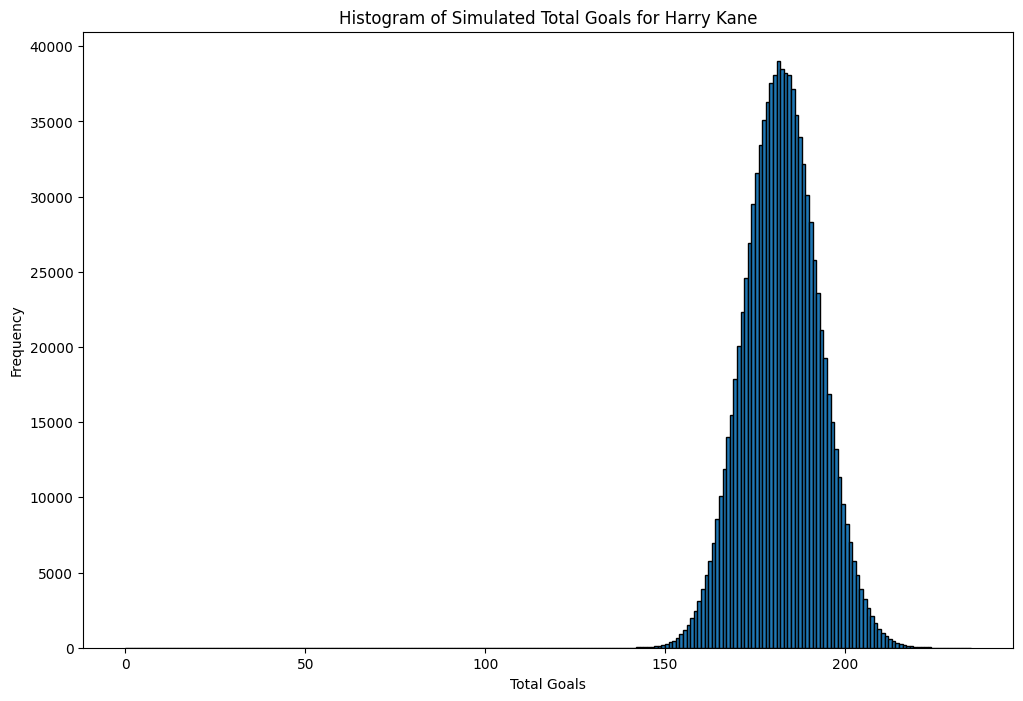

CPU times: total: 1min 19s
Wall time: 6min 12s


In [44]:
%%time
from matplotlib import pyplot as plt
plt.figure(figsize=(12,8))

num_simulations = 1000000
simulated_goals = []

for i in range(num_simulations):
    harry_kane['random'] = np.random.rand(len(harry_kane))
    harry_kane['simulated_goal'] = np.where(harry_kane['random'] < harry_kane['xG'],1,0)
    simulated_total_goals = harry_kane['simulated_goal'].sum()
    simulated_goals.append(simulated_total_goals)

# Plotting a histogram of simulated total goals
plt.hist(simulated_goals, bins=range(0, max(simulated_goals) + 1), align='mid', edgecolor='black')
plt.xlabel('Total Goals')
plt.ylabel('Frequency')
plt.title('Histogram of Simulated Total Goals for Harry Kane')
plt.show()

In [77]:
# Convert the simulated_goals list to a NumPy array
simulated_goals_array = np.array(simulated_goals)

np.sum(simulated_goals_array > 181) / num_simulations

0.512467

In [71]:
np.mean(simulated_goals_array)

181.901844

In [72]:
np.median(simulated_goals_array)

182.0

In [64]:
np.max(simulated_goals_array)

235

In [65]:
np.min(simulated_goals_array)

132

In [66]:
# Calculate the maximum number of goals
max_goals = np.max(simulated_goals_array)

# Count the number of times the maximum number of goals occurred
occurrences_of_max_goals = np.count_nonzero(simulated_goals_array == max_goals)
occurrences_of_max_goals

1

In [87]:
grouped_goals_tally = harry_kane.groupby(['season']).sum().reset_index()
new_dataframe = grouped_goals_tally[['season', 'xG', 'goal']]
new_dataframe

,season,xG,goal
0,2014,17.157292,21
1,2015,22.732069,25
2,2016,19.820097,29
3,2017,26.859891,30
4,2018,16.122395,17
5,2019,13.297068,18
6,2020,22.174856,23
7,2021,20.685066,17
8,2022,23.064434,30


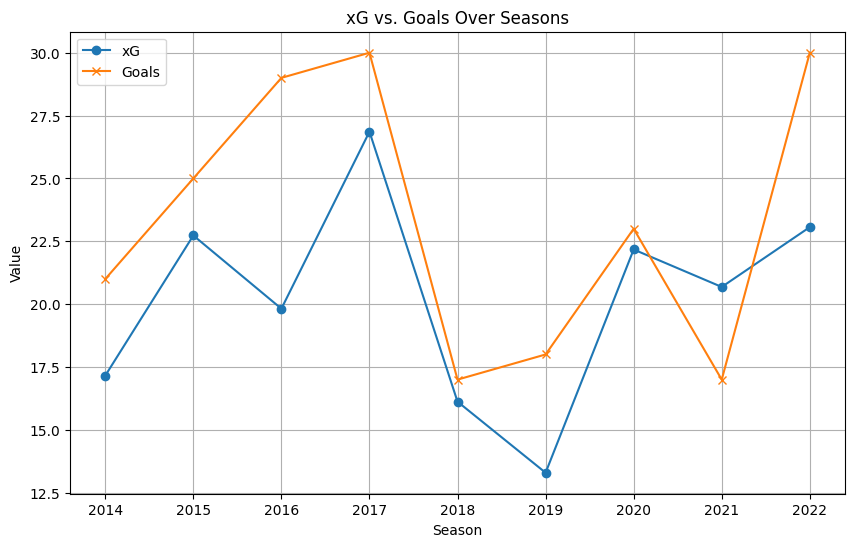

In [88]:
# Extract the 'season' and 'xG' columns for plotting
seasons = new_dataframe['season']
xG = new_dataframe['xG']
goals = new_dataframe['goal']

# Create a line plot for xG
plt.figure(figsize=(10, 6))
plt.plot(seasons, xG, label='xG', marker='o')
plt.plot(seasons, goals, label='Goals', marker='x')

# Customize the plot
plt.title('xG vs. Goals Over Seasons')
plt.xlabel('Season')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()